# Projet P4 : Anticipez les besoins en consommation de bâtiments - Implémentation modèle (target = consommation)

## Rappel des étapes du projet :

Des relevés de consommations et émissions des bâtiments non destinés à l’habitation ont été effectués par les agents de la ville en 2016. A partir de ces relevé, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels ces données n'ont pas été mesurées.

- <b> Etape préliminaire : </b> Importation des données et description des fichiers ( --> NoteBook1 : Analyse exploratoire )
- <b> Etape 1 : </b> Analyse exploratoire des datasets et premiers feature engineering ( --> NoteBook1 : Analyse exploratoire ) 
- <b> Etape 2 : </b> Développement et simulation d'un premier modèle ( --> NoteBook2 : Implémentation modèle )
- <b> Etape 3 : </b> Amélioration du feature engineering ( --> NoteBook2 : Implémentation modèle )
- <b> Etape 4 : </b> Simulation d'autres modèles et choix du modèle final ( --> NoteBook2 : Implémentation modèle )
- <b> Etape 5 : </b> Analyse de la "feature importance" globale et locale ( --> NoteBook2 : Implémentation modèle )
- <b> Etape 6 : </b> Analyse de l'influence de l'EnergyStarScore ( --> NoteBook2 : Implémentation modèle )
- <b> Etape 7 : </b> Simulation de la 2ème target ( --> NoteBook3 : Modèle 2e target )

### Environnement de travail et librairies

In [ ]:
# !Python3 -v // 3.11

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modele selection
from sklearn import model_selection
from sklearn.model_selection import KFold

# Estimators :
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge # RidgeCV
from sklearn.linear_model import Lasso # LassoCV
from sklearn.linear_model import ElasticNet # ElasticNetCV pour faire la validation croisée directement
from sklearn.linear_model import LogisticRegression # Pour la classification
from sklearn.svm import LinearSVR # LinearSVC pour la classification
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor # RandomForestClassifier pour la classification
from sklearn.ensemble import GradientBoostingRegressor # GradientBoostingClassifier pour la classification
from sklearn import kernel_ridge # Regression ridge à noyau

# Metrics :
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Standardiser les données
from sklearn.preprocessing import StandardScaler
from math import log
from scipy.special import expit

# Feature importance :
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## ETAPE 2 : Développement et simulation de plusieurs modèles

ETAPE 2
1. Charger les données
2. Scinder les données en train / test
3. Selectionner le modèle de données (variations feature engineering)
4. Normaliser les variables
5. Créer un modèle de base = baseline pour l'évaluation de la performance
6. Implémenter une fonction permettant de définir un modèle, tester ses hyper-paramètres par validation croisée et en évaluer sa performance
    - Utiliser une approche de validation croisée pour définir les meilleurs hyper-paramètres du modèle
    - entrainer le meilleur modèle
    - évaluer la performance du modèle avec des mesures d'évaluation (comme le R², MAPE, RMSE, le temps d'entrainement et d'inférence, sélection d'une métrique qui correspond le mieux au problème que vous résolvez).
7. Modèles simples de régression linéaire : classique - Ridge - Lasso - ElasticNet
8. Modèles non linéaires : SVM - Modèles ensemblistes
    - Considérez l'utilisation de méthodes d'ensemble comme le Bagging, le Boosting ou le Stacking, qui peuvent contribuer à améliorer la robustesse du modèle en combinant plusieurs modèles sous-optimaux.

## ETAPE 3 : Amélioration du feature engineering

Intégré au point 2. de l'étape 2 (mode itératif) : 
- MODELE2 : Retirer du modèles les hôpitaux qui peuvent biaiser le modèle
- MODELE3 : Ajouter les variables d'usage des bâtiments
- Autres pistes

Il existe de nombreuse technique de feature engineering dans scikitlearn, notamment : 
   - Feature selection, selection de variables
   - Feature engineering, transformation des variables
   - Dimensionality reduction, réduction de dimension (ACP,etc)

### 1. Charger les données

In [2]:
### Récupérer le fichier cleané dans le notebook 1
building_energy_MODELE = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P4\\data\\Building_Energy_MODELE.csv", index_col=0)
building_energy_MODELE.head()

,Parking_yes_no,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore,Steam_%,Electricity_%,NaturalGas_%,NumberofBuildings,NumberofFloors,Latitude,...,TLPUT_Refrigerated Warehouse,TLPUT_Restaurant,TLPUT_Retail Store,TLPUT_Self-Storage Facility,TLPUT_Social/Meeting Hall,TLPUT_Strip Mall,TLPUT_Supermarket/Grocery Store,TLPUT_Swimming Pool,TLPUT_Vocational School,TLPUT_Worship Facility
0,0,88434,0,60.0,0.277302,0.546060,0.176638,1.0,12,47.61220,...,0,0,0,0,0,0,0,0,0,0
1,1,88502,15064,61.0,0.000000,0.386609,0.613391,1.0,11,47.61317,...,0,1,0,0,0,0,0,0,0,0
2,1,759392,196718,43.0,0.297113,0.682307,0.020579,1.0,41,47.61393,...,0,0,0,0,0,0,0,0,0,0
3,0,61320,0,56.0,0.325913,0.407519,0.266567,1.0,10,47.61412,...,0,0,0,0,0,0,0,0,0,0
4,1,113580,62000,75.0,0.000000,0.378802,0.621198,1.0,18,47.61375,...,0,0,0,0,0,0,0,1,0,0


### 2. Scinder les données en train / test

In [3]:
# Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 25% des données.
X_train, X_test, y_train, y_test = model_selection.train_test_split(building_energy_MODELE.drop(columns=['SiteEnergyUse(kBtu)']),building_energy_MODELE['SiteEnergyUse(kBtu)'], test_size=0.25, random_state=40) #, stratify = building_energy_MODELE['PPT_Hospital'] 
# 25% des données dans le jeu de test
# random_state=N --> pour que la fonction fasse toujours le même split

In [4]:
# Il faut spliter le train/test avant de selectionner le modèle de données 
# pour comparer les indicateurs de performance sur le même jeu de test à chaque fois

### 3. Selectionner le modèle de données (variations feature engineering)

#### --> Données modele1 : Modèle sur jeu de données initial

In [133]:
def adapt_model1(X_data): 
    """ Fonction permettant d'adapter les données du modèle 1 à tester """
    # Variables à conserver pour constituer le 1er modèle : 
    var_modele = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Steam_%',
              'Electricity_%', 'NaturalGas_%', 'NumberofBuildings', 'NumberofFloors', 'Latitude',
              'Longitude', 'Age_batiment']
    selected_var = X_data.filter(regex='^PPT_')

    # Soit X_data_MODELEX le df contenant les données qui vont entrer dans le modèle
    X_data_MODELE1 = pd.concat([X_data[var_modele], selected_var], axis=1)
    return X_data_MODELE1

In [134]:
# Modifier X_train et X_test pour tester le 1er modèle de données
X_train = adapt_model1(X_train)
X_test = adapt_model1(X_test)
X_modele1 = X_train

In [135]:
print(X_train.shape,X_test.shape)

(1123, 31) (375, 31)


#### Modification du modèle de données pour l'étape 3 :

#### --> Données modele2 : Modèle sur jeu de données filtré sans les hôpitaux et bâtiment 558 (autres)

In [5]:
def adapt_model2(X_data): 
    """ Fonction permettant d'adapter les données du modèle 2 à tester """
    # Filtre sur les hôpitaux (10 bâtiments)
    indices = X_data.loc[X_data['PPT_Hospital'] > 0].index
    X_data = X_data[X_data['PPT_Hospital'] < 1]
    # Variables à conserver pour constituer le 2e modèle : 
    var_modele = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Steam_%',
              'Electricity_%', 'NaturalGas_%', 'NumberofBuildings', 'NumberofFloors', 'Latitude',
              'Longitude', 'Age_batiment']
    selected_var = X_data.filter(regex='^PPT_')

    # Soit X_data_MODELEX le df contenant les données qui vont entrer dans le modèle
    X_data_MODELE2 = pd.concat([X_data[var_modele], selected_var], axis=1)
    return X_data_MODELE2, indices

In [6]:
# Modifier X_train et X_test pour tester le 2e modèle de données
X_train, indices_train = adapt_model2(X_train)
X_train = X_train.drop(558)
y_train = y_train.drop(indices_train)
y_train = y_train.drop(558)
X_test, indices_test = adapt_model2(X_test)
# X_test = X_test.drop(558)
y_test = y_test.drop(indices_test)
# y_test = y_test.drop(558)
X_modele2 = X_train

In [7]:
print(X_train.shape,X_test.shape)

(1112, 31) (375, 31)


#### --> Données modele3 : Modèle sur jeu de données filtré sans les hôpitaux et avec ajout des variables d'usage principal des bâtiments

In [202]:
def adapt_model3(X_data): 
    """ Fonction permettant d'adapter les données du modèle 3 à tester """
    # Filtre sur les hôpitaux (10 bâtiments)
    indices = X_data.loc[X_data['PPT_Hospital'] > 0].index
    X_data = X_data[X_data['PPT_Hospital'] < 1]
    # Variables à conserver pour constituer le 3e modèle : 
    var_modele = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Steam_%',
              'Electricity_%', 'NaturalGas_%', 'NumberofBuildings', 'NumberofFloors', 'Latitude',
              'Longitude', 'Age_batiment']
    selected_var = X_data.filter(regex='^PPT_|^LPUT_')

    # Soit X_data_MODELEX le df contenant les données qui vont entrer dans le modèle
    X_data_MODELE3 = pd.concat([X_data[var_modele], selected_var], axis=1)
    return X_data_MODELE3, indices

In [203]:
# Modifier X_train et X_test pour tester le 3e modèle de données
X_train, indices_train = adapt_model3(X_train)
y_train = y_train.drop(indices_train)
X_test, indices_test = adapt_model3(X_test)
y_test = y_test.drop(indices_test)
X_modele3 = X_train

#### --> Autres pistes de modèles de données
- Intégrer toutes les variables d'usage des bâtiments (second, third) avec les surfaces et réaliser ensuite une opération de réduction de dimensions
- Tester la stratification dans l'échantillonage train / test

### 4. Normaliser les variables

#### --> Centrer et réduire les variables explicatives

In [204]:
# Standardiser et conserver l'objet (utile pour l'opération inverse lors de l'interprétation du modèle)

In [8]:
# standardiser les données train et test :
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
# df=pd.DataFrame(X_train, columns=features, index=keep_ind)

#### --> Passer en log la variable target

In [9]:
# On ajoute 1 pour éviter log(0) et on transforme en log la variable target du train et du test :
series_train = (y_train.astype(float)+1)
series_test = (y_test.astype(float)+1)
y_train = series_train.apply(lambda x: log(x))
y_test = series_test.apply(lambda x: log(x))

### 5. Implémenter un prédicteur naïf

In [10]:
# Prédictions le prédicteur naïf = moyenne des données y_train:
# Calculer la moyenne de y_train
y_train_mean = np.exp(y_train).mean()

# Créer une série Pandas des valeurs de y_train_mean
y_pred_series_naif = pd.Series([y_train_mean] * X_test.shape[0])
# Convertir la série en DataFrame si nécessaire
y_pred_naif = pd.DataFrame(y_pred_series_naif, columns=['Predicted_Value'])

In [11]:
# Performances du modèle = Baseline
print(f"Root Mean Squared Error (RMSE)(y, y_pred): {np.sqrt(mean_squared_error((np.exp(y_test)-1), y_pred_naif)):.2e}")
# RMSE baseline modele1 = 1.53e+07
# RMSE baseline modele2 = 1.10e+07
# RMSE baseline modele3 = 1.10e+07

Root Mean Squared Error (RMSE)(y, y_pred): 1.13e+07


### 6. Fonction pour implémenter un modèle et l'évaluer

In [12]:
# On peut calculer l'écart entre les vraies valeurs de test (y_test) et celles prédites par le modèle.
# Utilisons la RMSE et la MAE. Pour ces 2 métriques, une valeur plus petite correspond à un meilleur modèle.
# MAE est compris entre 0 et 1, tandis que RMSE n'est pas contraint.

# print(f"mean_absolute_error(y, y_pred): {mean_absolute_error(np.exp(y_test), np.exp(y_pred))}")
# print(f"mean_absolute_percentage_error(y, y_pred): {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))}")

In [23]:
# Faire une fonction pour définir un modèle, tester les hyper-paramètres par validation croisée, 
# entrainer le modele choisi et évaluer les indicateurs de performance du modèle

def modele_estime(estimator,parametres,folds, X1,y1,X2,y2):
    """Renvoie le résultat du modèle avec les principaux indicateurs de performance
        0. X1,y1 = train set - X2,y2 = test set
        1. Définition du modèle avec la liste de paramètres à tester
        2. Entrainement du modèle sur le train 
        3. Les meilleurs paramètres du modèle
        4. Le score R² du modèle sur le train
        5. Prédictions pour X_test, R² sur le test et calcul de la RMSE
        6. Temps d'entrainement du modèle """
    
    # 1. Définition du modèle avec la liste de paramètres à tester
    # RandomSearch à la place de GridSearch est moins exhaustif pour tester les paramètres 
    # (échantillon aléatoire des hyper paramètres) mais prend moins de temps
    modele = model_selection.GridSearchCV(
    estimator, # un estimateur
    param_grid=parametres,
    cv=folds,      # nombre de folds de validation croisée
    scoring='r2'   # score à optimiser
    )
    # 2. Entrainement du modèle sur le jeu d'entraînement
    modele.fit(X1, y1)
    
    # 3. Les meilleurs paramètres du modèle
    print(f"Les meilleurs paramètres du modèle sont : {modele.best_params_}")
    
    # 4. Le score R² du modèle 
    print(f"Score R² sur le train : {modele.best_score_}")
    
    # 5. Prédictions pour X_test et calcul de la RMSE pour identifier le meilleur modèle
    # GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement
    y_pred = modele.predict(X2)
    print(f"Score R² test : {r2_score(y2, y_pred)}")
    # On peut calculer l'écart entre les vraies valeurs de test (y_test) et celles prédites par le modèle.
    # On applique np.exp sur mes prédictions en log pour repasser sur les vrai valeurs
    print(f"Root_mean_squared_error(y, y_pred): {np.sqrt(mean_squared_error((np.exp(y2-1)), (np.exp(y_pred-1)))):.2e}")
    
    # 6. Temps d'entrainement du modèle :
    temps_moyen_ajustement = modele.cv_results_['mean_fit_time'][modele.best_index_]
    print("Temps moyen d'ajustement du meilleur modèle (secondes):", temps_moyen_ajustement)
    # Temps d'inférence du modèle :
    temps_moyen_inference = modele.cv_results_['mean_score_time'][modele.best_index_]
    print("Temps moyen d'inférence du meilleur modèle (secondes):", temps_moyen_inference)
    
    return modele

### 7. Régression linéaire
Développer un modèle de régression linéaire pour prédire la conso d'énergie.

#### 1. Regression linéaire classique

COURS : https://openclassrooms.com/fr/courses/4444646-entrainez-un-modele-predictif-lineaire/8270106-tp-entrainez-une-regression-logistique-et-une-svm-lineaire

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn-model-selection-gridsearchcv

In [164]:
parametres = {
    'fit_intercept': [True,False], # En mettant fit_intercept = False, le modèle est meilleur
    'n_jobs': [-1, 1, 2]  # différentes valeurs pour le nombre de processus (-1 = tous)
}
# Hyper-paramètres possibles à tester :
# fit_intercept: Un booléen indiquant si l'intercept doit être estimé. La valeur par défaut est True.
# normalize: Un booléen indiquant si les variables d'entrée doivent être normalisées avant la régression. La valeur par défaut est False.
# n_jobs: Le nombre de processeurs à utiliser pour les calculs. La valeur par défaut est 1, ce qui signifie qu'un seul processus est utilisé. Si vous spécifiez -1, tous les processeurs disponibles seront utilisés.

modele = modele_estime(LinearRegression(),parametres,5,X_train,y_train,X_test,y_test)
# On reste sur n_folds = 5 pour comparer les modèles

Les meilleurs paramètres du modèle sont : {'fit_intercept': False, 'n_jobs': -1}
Score R² sur le train : -163102.04738990153
Score R² test : -6.981541183662792e+26


overflow encountered in exp


ValueError: Input contains infinity or a value too large for dtype('float64').

<div class="alert alert-block alert-info">
    <b> ---> REGRESSION LINEAIRE: </b>
    La régression linéaire est très instable, le R² sur le train et test sont très mauvais. La regressions est énormément influencée par les valeurs extêmes et donc très dépendante du split initial des données entre train et test. Les valeurs extrêmes tirent la droite et cela créé des valeurs très élevées dans les prédictions (d'où des erreurs sur le passage à l'exponentielle). On regardant de plus près les résultats, on voit que les variables binaires (=types de bâtiments) ont des coefficients très élevés en valeur absolue, les variables binaires ne sont généralement pas très appropriées pour une regression linéaire. 
</div>

#### --> Application de deux algorithmes de régularisation de la régression linéaire : la régression ridge et le lasso.

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

The Lasso is a linear model that estimates sparse coefficients with l1 regularization.

Elastic-Net is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

#### 2. Régression ridge

Pour la régression ridge, on doit trouver un coefficient de régularisation adapté. On appelle ce coefficient alpha, on va en tester un certain nombre afin de trouver celui qui est optimal.
La régression Ridge diminue grandement l'influence de certaines variables sur le modèle.

linear_model.RidgeCV permet de déterminer la valeur optimale du coefficient de régularisation par validation croisée.

In [165]:
parametres = {
    'alpha': [0.0001,0.001,0.01,0.1,1,10,100],
    'fit_intercept': [True, False]
}
# Hyper-paramètres possibles à tester :
# alpha: C'est une liste ou un tableau de valeurs alpha à tester pour la régularisation. Par défaut, RidgeCV teste une plage de valeurs logarithmiquement échantillonnées entre 1e-10 et 1e3.
# fit_intercept: Un booléen indiquant si l'intercept doit être estimé. La valeur par défaut est True.
# normalize: Un booléen indiquant si les variables d'entrée doivent être normalisées avant la régression. La valeur par défaut est False.

modele = modele_estime(Ridge(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 10, 'fit_intercept': True}
Score R² sur le train : 0.5653195377177465
Score R² test : 0.5944447118787322
Root_mean_squared_error(y, y_pred): 7.80e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 0.007619142532348633
Temps moyen d'inférence du meilleur modèle (secondes): 0.000948333740234375


In [145]:
# Enregistrer le meilleur modele pour en extraire les informations
reg_ridge = modele.best_estimator_
y_pred = reg_ridge.predict(X_test)

In [146]:
# Récupérer les noms des colonnes de X_train
column_names = X_modele1.columns
# Créer un DataFrame avec les noms de colonnes et les coefficients
coefficients_df = pd.DataFrame({'Feature': column_names, 'Coefficient': reg_ridge.coef_})
coefficients_df['Absolute_Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values('Absolute_Coefficient', ascending=False)
coefficients_df
# On voit que les variables : NumberofFloors, PPT_Retail Store, PPT_Residence Hall n'ont pas beaucoup d'impact

,Feature,Coefficient,Absolute_Coefficient
0,PropertyGFABuilding(s),0.504040,0.504040
29,PPT_Warehouse,-0.275703,0.275703
15,PPT_Large Office,0.257277,0.257277
30,PPT_Worship Facility,-0.211622,0.211622
27,PPT_Supermarket / Grocery Store,0.189443,0.189443
24,PPT_Self-Storage Facility,-0.167277,0.167277
9,Age_batiment,-0.154998,0.154998
10,PPT_Distribution Center,-0.148769,0.148769
14,PPT_Laboratory,0.135971,0.135971
12,PPT_Hotel,0.108607,0.108607


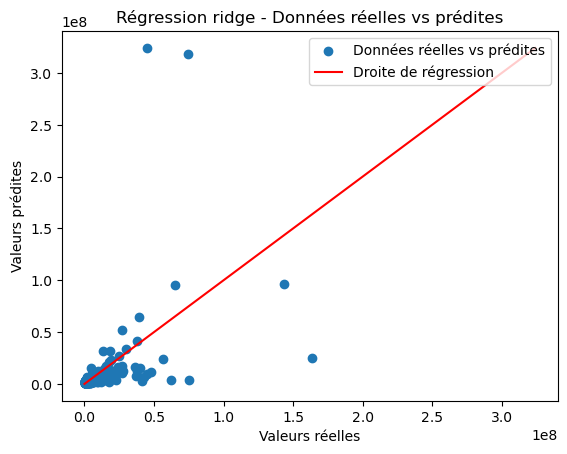

In [147]:
# Tracer un nuage de points entre les valeurs réelles et prédites
plt.scatter(np.exp(y_test), np.exp(y_pred), label='Données réelles vs prédites')

# Tracer la droite de régression linéaire entre valeurs réelles et prédites
max_value = max(np.max(np.exp(y_test)), np.max(np.exp(y_pred)))
plt.plot([0, max_value], [0, max_value], color='red', label='Droite de régression')

# Ajouter des labels et un titre
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Régression ridge - Données réelles vs prédites')
plt.legend(loc='upper right')

# Limiter les axes pour une meilleure visualisation
# plt.xlim(-10000000, 100000000)
# plt.ylim(-10000000, 100000000)

plt.show()

#### 3. Lasso

On teste aussi un certain nombre d'hyperparamètres pour appliquer le lasso.
Le lasso peut directement supprimer certaines variables du modèle (mettre leur poids à zéro), et donc être parcimonieux.

In [166]:
parametres = {
    'alpha': [0.001,0.01,0.1,1,10],
    'fit_intercept': [True, False],
    'precompute': [True, False],
    'max_iter': [5000]
}
# Hyper-paramètres possibles à tester :
# alpha: C'est une liste ou un tableau de valeurs alpha à tester pour la régularisation. Par défaut 1.
# fit_intercept: Un booléen indiquant si l'intercept doit être estimé. La valeur par défaut est True.
# precompute: Un booléen ou un tableau indiquant si le calcul préliminaire est effectué pour accélérer les calculs. La valeur par défaut est False.
# max_iter: Le nombre maximum d'itérations. La valeur par défaut est 1000.
# tol: La tolérance pour la convergence. La valeur par défaut est 1e-4.
# 'copy_X' : copie des données X, par défaut True
# 'positive' : bool, default=False. When set to True, forces the coefficients to be positive.
# 'random_state'
# 'selection'
# 'warm_start' : bool, default=False. When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. 

modele = modele_estime(Lasso(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'fit_intercept': True, 'max_iter': 5000, 'precompute': True}
Score R² sur le train : 0.5651770170226866
Score R² test : 0.5950141710948689
Root_mean_squared_error(y, y_pred): 7.90e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 0.006284904479980469
Temps moyen d'inférence du meilleur modèle (secondes): 0.0


#### 4. ElasticNet

L'elastic net combine les normes ℓ1 et ℓ2 pour obtenir une solution moins parcimonieuse que le lasso, mais plus stable et dans laquelle toutes les variables corrélées pertinentes pour la prédiction de l'étiquette sont sélectionnées et reçoivent un poids identique.

In [24]:
parametres = {
    'alpha': [0.01,0.1,1,10],
    'l1_ratio': [.1,.2,.3,.4, .5, .7, .9, .95, .99,1],
    'fit_intercept': [True, False],
    'precompute': [True, False],
    'max_iter': [5000]
    }

# Hyper-paramètres possibles à tester :
# alpha: C'est une liste ou un tableau de valeurs alpha à tester pour la régularisation. Par défaut, ElasticNetCV teste une plage de valeurs logarithmiquement échantillonnées entre 1e-10 et 1e3.
# l1_ratio: Une liste de valeurs ou un nombre compris entre 0 et 1 indiquant le mélange de régularisation l1 et l2. Un l1_ratio de 0 correspond à une régression Ridge (l2), un l1_ratio de 1 correspond à une régression Lasso (l1), et toute valeur entre 0 et 1 correspond à une régression ElasticNet avec un mélange des deux.
# fit_intercept: Un booléen indiquant si l'intercept doit être estimé. La valeur par défaut est True.
# precompute: Un booléen ou un tableau indiquant si le calcul préliminaire est effectué pour accélérer les calculs. La valeur par défaut est False.
# max_iter: Le nombre maximum d'itérations. La valeur par défaut est 1000.
# copy_X
# tol: La tolérance pour la convergence. La valeur par défaut est 1e-4.
# warm_start
# positive
# random_state
# selection

modele = modele_estime(ElasticNet(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.7, 'max_iter': 5000, 'precompute': True}
Score R² sur le train : 0.5717972359631396
Score R² test : 0.5832999554385995
Root_mean_squared_error(y, y_pred): 1.30e+07
Temps moyen d'ajustement du meilleur modèle (secondes): 0.0008029460906982422
Temps moyen d'inférence du meilleur modèle (secondes): 0.0


<div class="alert alert-block alert-info">
    <b> ---> COMPARAISON DES MODELES DE REGRESSION LINEAIRE: </b>
    La régularisation permet d'améliorer de manière très nette le modèle. Les outliers pénalisent énormément l'apprentissage et le fait de donner un poids moins élevé sur les variables binaires permet de corriger cela. Néanmoins pour le modèle Lasso l'algorithme converge difficilement. 
</div>

### 8. Tester d'autres modèles : SVM à noyaux - modèles ensemblistes

#### 1. SVM à noyaux

In [25]:
parametres = {
    'kernel':['rbf'], #'kernel':['poly','rbf','sigmoid','linear'],
    #'degree':[2,3,4],
    'gamma':['auto'], #'gamma':['scale', 'auto'],
    'coef0':[0,0.1,1,10], #'coef0':[0,0.1,1,10],
    'C': [1], #'C': [0.001,0.01,0.1,1,10],
    'epsilon': [0.2] #'epsilon': [0.001,0.01,0.1,0.2]
}

# Hyper-paramètres possibles à tester :
# 'kernel':['linear','poly','rbf','sigmoid','precomputed'],
# kernel: Le noyau à utiliser dans le modèle SVR. Les options courantes sont "linear" pour une SVR linéaire, "rbf" pour une SVR avec un noyau gaussien (radial basis function), et "poly" pour une SVR avec un noyau polynomial. La valeur par défaut est "rbf".
# C: Le paramètre de régularisation. Il contrôle la pénalité sur les erreurs d'entraînement. Une valeur plus élevée de C entraîne une pénalité plus importante sur les erreurs d'entraînement, ce qui peut conduire à un modèle avec une meilleure performance sur les données d'entraînement mais potentiellement moins généralisable. La valeur par défaut est 1.0.
# epsilon: La marge d'erreur tolérée. Cela contrôle la largeur de la bande de tolérance autour de la ligne de régression où aucune pénalité n'est appliquée à l'erreur. Une valeur plus élevée d'epsilon permet de tolérer des erreurs plus importantes, ce qui peut conduire à un modèle plus robuste face au bruit dans les données. La valeur par défaut est 0.1.
# gamma: Le coefficient gamma pour les noyaux "rbf", "poly" et "sigmoid". Ce paramètre définit l'influence des exemples d'entraînement sur le modèle. Une valeur plus élevée de gamma signifie que les exemples d'entraînement plus proches ont un poids plus important dans la prédiction.
# degree: Le degré du noyau polynomial. Ce paramètre est utilisé uniquement si kernel='poly'. La valeur par défaut est 3.
# kernel_params
# coef0
# tol : float, default=1e-4. Tolerance for stopping criteria.
# shrinking
# cache_size
# verbose
# max_iterint, default=-1. Hard limit on iterations within solver, or -1 for no limit.

modele = modele_estime(SVR(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'C': 1, 'coef0': 0, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}
Score R² sur le train : 0.6165529560894153
Score R² test : 0.6642450282044692
Root_mean_squared_error(y, y_pred): 2.47e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 0.06588354110717773
Temps moyen d'inférence du meilleur modèle (secondes): 0.014198970794677735


#### 2. Modèle ensembliste parallèle : RandomForest

In [16]:
parametres = {
    'n_estimators': [100], #'n_estimators': [50,100],
    'max_depth': [15], #'max_depth': [2,5,10,15,20,None],
    'criterion': ['squared_error'], #'criterion': ['squared_error', 'absolute_error'],
    
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10],
    # 'min_samples_leaf': [2,5,10],
    'max_features': [0.5] # racine du nb de variables
}
# Hyper-paramètres possibles à tester :
# n_estimators: Le nombre d'arbres dans la forêt aléatoire.
# criterion: La fonction utilisée pour mesurer la qualité d'une scission. Pour la régression, les options sont généralement "mse" pour l'erreur quadratique moyenne et "mae" pour l'erreur absolue moyenne.
# max_features: Le nombre maximal de caractéristiques à considérer lors de la recherche de la meilleure scission. Vous pouvez spécifier un nombre fixe, un pourcentage ou une fonction.
# max_depth: La profondeur maximale de chaque arbre de décision dans la forêt. Une profondeur plus grande peut entraîner un surajustement, tandis qu'une profondeur plus petite peut entraîner un sous-ajustement.
# min_samples_split: Le nombre minimum d'échantillons requis pour scinder un nœud interne. Cela peut aider à contrôler la croissance de l'arbre et à éviter le surajustement.
# min_samples_leaf: Le nombre minimum d'échantillons requis pour être au niveau d'une feuille. Cela peut aider à contrôler la taille finale des feuilles de l'arbre et à éviter le surajustement.
# bootstrap: Si les échantillons doivent être tirés avec remplacement lors de la construction des arbres. Cela aide à contrôler la variabilité des modèles et peut aider à améliorer les performances en moyenne.
# random_state: Contrôle la reproductibilité des résultats en initialisant le générateur de nombres aléatoires.
# criterion{“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error”
# min_weight_fraction_leaf
# max_leaf_nodes
# min_impurity_decrease
# bootstrap
# oob_score
# n_jobs
# verbose
# warm_start
# ccp_alpha
# max_samples
# monotonic_cst

modele = modele_estime(RandomForestRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 0.5, 'n_estimators': 100}
Score R² sur le train : 0.6886151114913308
Score R² test : 0.7206952771053237
Root_mean_squared_error(y, y_pred): 2.32e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 1.3881232261657714
Temps moyen d'inférence du meilleur modèle (secondes): 0.01883249282836914


#### 3. Modèle ensembliste séquentiel : GradientBoosting

In [17]:
parametres = {
    'loss':['absolute_error'], #'loss':['squared_error','absolute_error','huber','quantile'],
    'learning_rate': [0.1], #'learning_rate': [0.001,0.01,0.1,10,100],
    'n_estimators': [100], #'n_estimators': [20,50,100,150,200],
    'max_depth': [10], #'max_depth': [2,5,10,15,20],
    'subsample': [0.2], #'subsample': [0.01,0.1,0.2],
    # 'min_samples_split': [10], #'min_samples_split': [2,5,10,15,20],
    # 'min_samples_leaf': [2], #'min_samples_leaf': [2,5,10,15,20],
    'alpha': [0.01,0.1] #[0.0001,0.001,0.01,0.1, 1, 10, 100]
}
# Hyper-paramètres possibles à tester :
# n_estimators: Le nombre d'estimateurs de boosting à ajuster. C'est le nombre d'itérations de boosting.
# learning_rate: Le taux d'apprentissage (ou de rétrécissement) réduit la contribution de chaque arbre. Une valeur plus faible rend le modèle plus robuste en général, mais nécessite un nombre plus élevé d'estimateurs.
# max_depth: La profondeur maximale des arbres de régression. Il contrôle la complexité de chaque arbre.
# min_samples_split: Le nombre minimum d'échantillons requis pour diviser un nœud interne. Une valeur plus élevée peut aider à prévenir le surajustement.
# min_samples_leaf: Le nombre minimum d'échantillons requis pour être au niveau d'une feuille. Cela peut aider à contrôler la taille finale des feuilles de l'arbre.
# subsample: La fraction d'échantillons à utiliser pour adapter les arbres individuels. Une valeur inférieure à 1.0 entraîne un Gradient Boosting stochastique, ce qui peut aider à réduire le surajustement.
# loss: La fonction de perte à optimiser. Pour la régression, la perte par défaut est l'erreur quadratique.
# criterion: La fonction utilisée pour évaluer la qualité de la scission dans chaque arbre. Pour la régression, la valeur par défaut est "friedman_mse", mais vous pouvez également spécifier 'squared_error'.
# random_state: Contrôle la reproductibilité des résultats en initialisant le générateur de nombres aléatoires.
# min_weight_fraction_leaf
# max_depth
# min_impurity_decrease
# init
# max_features
# alpha : The alpha-quantile of the huber loss function and the quantile loss function. Only if loss='huber' or loss='quantile'. Values must be in the range (0.0, 1.0).
# verbose
# max_leaf_nodes
# warm_start
# validation_fraction
# n_iter_no_change
# tol
# ccp_alpha

modele = modele_estime(GradientBoostingRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'alpha': 0.01, 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.2}
Score R² sur le train : 0.6603777074395698
Score R² test : 0.7035025292289204
Root_mean_squared_error(y, y_pred): 2.49e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 1.734050416946411
Temps moyen d'inférence du meilleur modèle (secondes): 0.006381797790527344


## ETAPE 4 : Choix du modèle final et selection des hyper-paramètres optimaux

ETAPE 4
1. Choix du modèle final : Random Forest
2. Test et optimisation des hyper-paramètres de manière plus exhaustive

In [40]:
parametres = {
    'n_estimators': [100], #'n_estimators': [20,50,100],
    'max_depth': [15], #'max_depth': [2,5,10,15,20,None],
    'criterion': ['squared_error'], #'criterion': ['squared_error', 'absolute_error'],
    'max_features': [0.5] # % de variables : 'max_features': [0.2,0.5,0.8,1]
}

modele = modele_estime(RandomForestRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 0.5, 'n_estimators': 100}
Score R² sur le train : 0.6940412283956838
Score R² test : 0.6760366360794561
Root_mean_squared_error(y, y_pred): 2.40e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 0.5696405410766602
Temps moyen d'inférence du meilleur modèle (secondes): 0.0057166099548339845


In [41]:
# Enregistrer le meilleur modele pour en extraire les informations
random_forest = modele.best_estimator_
y_pred = random_forest.predict(X_test)

In [42]:
print(f"mean_absolute_error(y, y_pred): {mean_absolute_error((np.exp(y_test-1)), (np.exp(y_pred-1))):.2e}")
print(f"mean_absolute_percentage_error(y, y_pred): {mean_absolute_percentage_error((np.exp(y_test-1)), (np.exp(y_pred-1))):.2e}")

mean_absolute_error(y, y_pred): 1.06e+06
mean_absolute_percentage_error(y, y_pred): 5.65e-01


In [59]:
X_test_df = pd.DataFrame(X_test, columns=np.array(X_modele2.columns))
# Concaténer les colonnes calculées avec X_test_df
X_test_df['y_test_exp'] = np.exp(y_test)
X_test_df['y_pred_exp'] = np.exp(y_pred)
X_test_df['type_batiment'] = building_energy_MODELE['PrimaryPropertyType']
X_test_df.head()

# Filtrer la colonne 'PrimaryPropertyType' pour obtenir uniquement les indices présents dans y_test
filtered_property_type = building_energy_MODELE.loc[y_test.index, 'PrimaryPropertyType']
# Concaténer cette colonne filtrée avec y_test
result = pd.concat([filtered_property_type, y_test], axis=1)
# Renommer les colonnes pour une meilleure clarté
result.columns = ['PrimaryPropertyType', 'y_test']
result['y_test_exp'] = np.exp(result['y_test'])
result['y_pred_exp'] = np.exp(y_pred)

(372, 4)

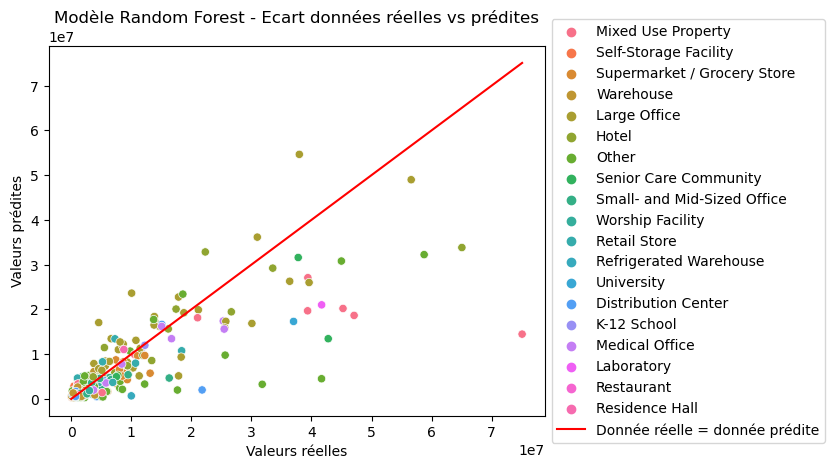

In [62]:
# Tracer un nuage de points entre les valeurs réelles et prédites
# plt.scatter(np.exp(y_test), np.exp(y_pred), label='Données réelles vs prédites')

sns.scatterplot(data=result, x='y_test_exp', y='y_pred_exp', hue='PrimaryPropertyType')

# Tracer la droite de régression linéaire entre valeurs réelles et prédites
max_value = max(np.max(np.exp(y_test)), np.max(np.exp(y_pred)))
plt.plot([0, max_value], [0, max_value], color='red', label='Donnée réelle = donnée prédite')

# Ajouter des labels et un titre
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Modèle Random Forest - Ecart données réelles vs prédites')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Limiter les axes pour une meilleure visualisation
# plt.xlim(-10000000, 100000000)
# plt.ylim(-10000000, 100000000)

plt.show()

## ETAPE 5 : Analyse de la "feature importance" globale et locale

ETAPE 5
1. analyse de l'importance des caractéristiques globales dans le modèle final
2. compréhension des caractéristiques qui ont le plus d'influence sur les prédictions
3. représentations graphiques claires de ces différentes influences


Ressources :

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#plot-feature-importance

https://shap.readthedocs.io/en/latest/

https://lime-ml.readthedocs.io/en/latest/

### Interprétabilité du modèle : 
SHAP (SHapley Additive exPlanations) et LIME (Local Interpretable Model-agnostic Explanations) sont deux techniques populaires pour expliquer les prédictions des modèles de machine learning. Bien qu'ils poursuivent le même objectif d'expliquer les prédictions des modèles, ils ont des approches différentes pour le faire. Voici les principales différences entre SHAP et LIME :
1. Philosophie sous-jacente :
- SHAP est basé sur la théorie des jeux et les valeurs de Shapley, qui sont utilisées pour attribuer la contribution de chaque caractéristique à la prédiction du modèle.
- LIME se concentre sur l'interprétation locale des prédictions du modèle en ajustant un modèle explicite (généralement linéaire) aux prédictions du modèle principal autour de l'instance d'intérêt.
2. Approche de modélisation :
- SHAP utilise un modèle additif pour estimer les valeurs de Shapley et attribuer les contributions des caractéristiques.
- LIME utilise des modèles locaux simplifiés, souvent linéaires, pour approximer le modèle principal autour de l'instance d'intérêt.
3. Portée de l'explicabilité :
- SHAP fournit des explications globales et locales des prédictions du modèle. Les valeurs de Shapley peuvent être utilisées pour comprendre l'impact de chaque caractéristique sur l'ensemble des prédictions du modèle.
- LIME se concentre principalement sur les explications locales, fournissant des informations sur la contribution des caractéristiques à une prédiction spécifique pour une instance donnée.
4. Robustesse :
- SHAP est généralement considéré comme plus robuste que LIME car il est basé sur une base théorique solide et fournit des estimations cohérentes des contributions des caractéristiques.
- LIME peut être plus sensible aux choix de l'utilisateur, comme le nombre d'échantillons générés pour ajuster les modèles locaux.

In [228]:
# L'importance des caractéristiques basée sur l'impureté est une mesure utilisée dans les arbres de décision et les méthodes d'ensemble basées sur des arbres.
# Cette mesure est utilisée pour évaluer l'importance relative des caractéristiques dans la prise de décision du modèle.

In [229]:
# La méthode basée sur l'impureté peut être trompeuse avec des variables contenant beaucoup de modalités uniques, 
# en alternative : permutation_importance

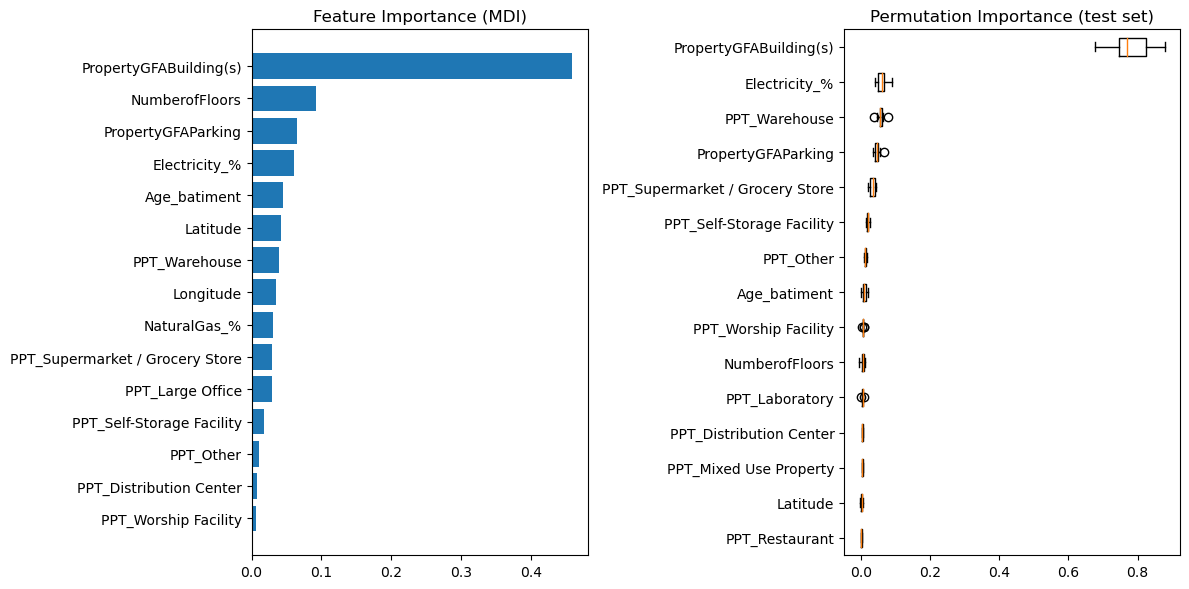

In [230]:
feature_importance = random_forest.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Tracer le graphique pour l'importance des features (MDI)
ax[0].barh(pos[-15:], feature_importance[sorted_idx][-15:], align="center")
ax[0].set_yticks(pos[-15:])
ax[0].set_yticklabels(np.array(X_modele3.columns)[sorted_idx][-15:])
ax[0].set_title("Feature Importance (MDI)")

# Tracer le graphique pour l'importance des features (permutation)
result = permutation_importance(
    random_forest, X_test, y_test, n_repeats=10, random_state=20, n_jobs=2
)
sorted_idx_perm = result.importances_mean.argsort()
ax[1].boxplot(
    result.importances[sorted_idx_perm].T[:, -15:],
    vert=False,
    labels=np.array(X_modele3.columns)[sorted_idx_perm][-15:],
)
ax[1].set_title("Permutation Importance (test set)")

plt.tight_layout()
plt.show()

In [232]:
X_train_df = pd.DataFrame(X_train, columns=np.array(X_modele2.columns))

In [233]:
# Determiner les SHAP values
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer(X_train_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


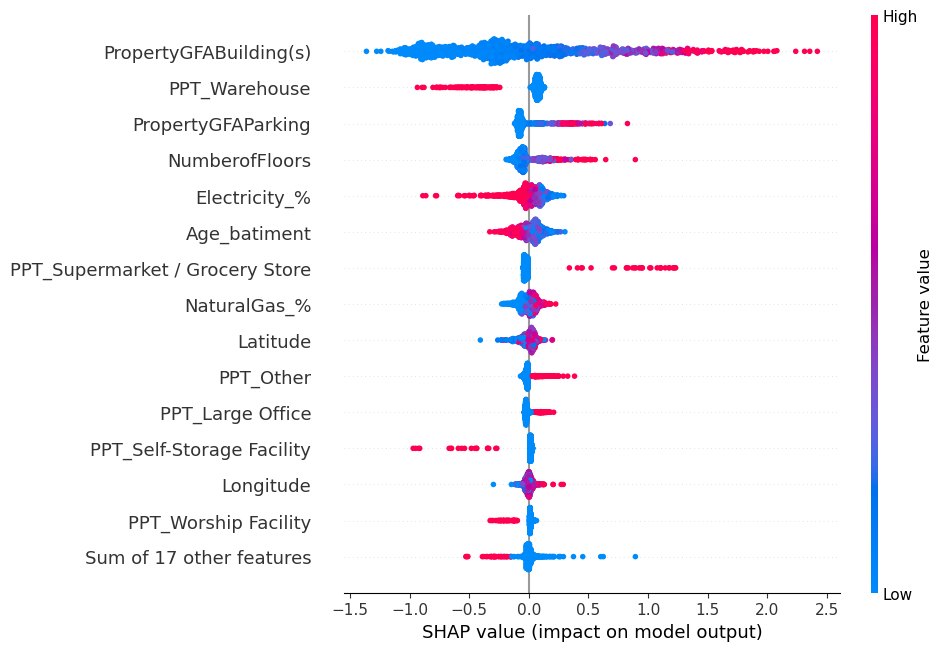

In [234]:
shap.plots.beeswarm(shap_values,max_display=15)

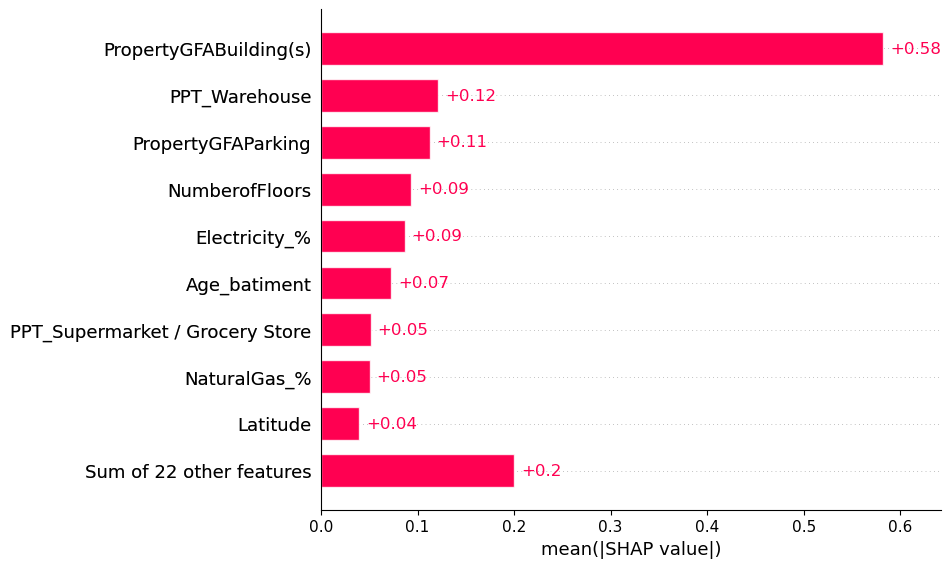

In [235]:
shap.plots.bar(shap_values)

## ETAPE 6 : Analyse de l'influence de l'EnergyStarScore

ETAPE 6
1. Déterminer l'importance de cette caractéristique dans le modèle
2. Faites un sous-ensemble du dataset permettant de tester correctement l’impact de cette caractéristique sur l’entraînement et les performances du modèle sélectionné.
3. Testez l'entraînement de votre modèle avec et sans cette caractéristique.

#### 1. On filtre sur les données avec la variable ENERGYSTARScore renseignée

In [40]:
# Création du dataset pour tester l'influence de l'EnergyStarScore
building_energy_filtre = building_energy_MODELE[building_energy_MODELE['PPT_Hospital'] < 1]
building_energy_filtre = building_energy_filtre[building_energy_filtre['ENERGYSTARScore'].notna()]

# Variables à conserver pour constituer le modèle : 
var_modele = ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'Steam_%',
              'Electricity_%', 'NaturalGas_%', 'NumberofBuildings', 'NumberofFloors', 'Latitude',
              'Longitude', 'Age_batiment','ENERGYSTARScore']
selected_var = building_energy_filtre.filter(regex='^PPT_')
target = ['SiteEnergyUse(kBtu)']

building_energy_MODELE_Score = pd.concat([selected_var,building_energy_filtre[var_modele], building_energy_filtre[target]], axis=1)
building_energy_MODELE_Score.shape

(970, 33)

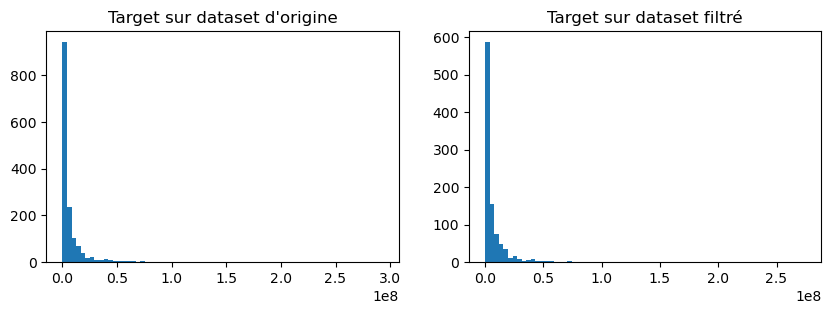

In [41]:
# Vérifier que la répartition des données reste la même sur les données filtrées : OK
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
axs[0].hist(building_energy_MODELE['SiteEnergyUse(kBtu)'], bins=70)
axs[0].set_title("Target sur dataset d'origine")
    
axs[1].hist(building_energy_filtre['SiteEnergyUse(kBtu)'], bins=70)
axs[1].set_title("Target sur dataset filtré")
    
plt.show()

In [42]:
# Soit Target la variable cible à prédire
target = building_energy_MODELE_Score['SiteEnergyUse(kBtu)']

# Soit X le df contenant les données qui vont entrer dans le modèle
X = building_energy_MODELE_Score.iloc[:, :-1]
keep_ind = X.index

In [43]:
# Standardiser les données et passer au log la target
X_scaled = StandardScaler().fit_transform(X)
series = (target.astype(float)+1)
y = series.apply(lambda x: log(x))

In [44]:
# Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 25% des données.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled,y, test_size=0.25, random_state=20)

In [45]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(727, 32) (243, 32) (727,) (243,)


#### 2. On lance une seconde fois le modèle AVEC la variable ENERGYSTARScore

In [46]:
# Paramétrer et entrainer le modèle
parametres = {
    'n_estimators': [100], #'n_estimators': [20,50,100],
    'max_depth': [15], #'max_depth': [2,5,10,15,20,None],
    'criterion': ['squared_error'], #'criterion': ['squared_error', 'absolute_error'],
    'max_features': [0.5] # % de variables : 'max_features': [0.2,0.5,0.8,1]
}

modele = modele_estime(RandomForestRegressor(),parametres,5,X_train,y_train,X_test,y_test)

Les meilleurs paramètres du modèle sont : {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 0.5, 'n_estimators': 100}
Score R² sur le train : 0.8167052036480917
Score R² test : 0.8994451528252905
Root_mean_squared_error(y, y_pred): 1.37e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 0.42783498764038086
Temps moyen d'inférence du meilleur modèle (secondes): 0.004976034164428711


- Score R² sur le train : 0.8135127338094016
- Score R² test : 0.899473013173372
- Root_mean_squared_error(y, y_pred): 1.36e+06
- Temps moyen d'ajustement du meilleur modèle (secondes): 2.0139826774597167
- Temps moyen d'inférence du meilleur modèle (secondes): 0.03217978477478027

In [47]:
# Enregistrer le meilleur modele pour en extraire les informations
random_forest = modele.best_estimator_
y_pred = random_forest.predict(X_test)

#### 3. On fait tourner un premier modèle SANS la variable ENERGYSTARScore

In [48]:
y_test_Sscore = y_test
y_train_Sscore = y_train

In [49]:
# Supprimez la colonne 'ENERGYSTARScore' de X_train et X_test
X_train_Sscore = np.delete(X_train, -1, axis=1)
X_test_Sscore = np.delete(X_test, -1, axis=1)

In [50]:
# Paramétrer et entrainer le modèle RandomForestRegressor() avec les hyper-paramètres optimaux
parametres = {
    'n_estimators': [100], #'n_estimators': [20,50,100],
    'max_depth': [15], #'max_depth': [2,5,10,15,20,None],
    'criterion': ['squared_error'], #'criterion': ['squared_error', 'absolute_error'],
    'max_features': [0.5] # % de variables : 'max_features': [0.2,0.5,0.8,1]
}

modele = modele_estime(RandomForestRegressor(),parametres,5,X_train_Sscore,y_train_Sscore,X_test_Sscore,y_test_Sscore)

Les meilleurs paramètres du modèle sont : {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 0.5, 'n_estimators': 100}
Score R² sur le train : 0.7503097257135389
Score R² test : 0.8373112834753448
Root_mean_squared_error(y, y_pred): 1.39e+06
Temps moyen d'ajustement du meilleur modèle (secondes): 0.38668036460876465
Temps moyen d'inférence du meilleur modèle (secondes): 0.010608386993408204


In [51]:
# Enregistrer le meilleur modele pour en extraire les informations
random_forest_Sscore = modele.best_estimator_
y_pred_Sscore = random_forest_Sscore.predict(X_test_Sscore)

- Score R² sur le train : 0.7495837771648984
- Score R² test : 0.8367139768800214
- Root_mean_squared_error(y, y_pred): 1.51e+06
- Temps moyen d'ajustement du meilleur modèle (secondes): 1.7971290588378905
- Temps moyen d'inférence du meilleur modèle (secondes): 0.030748510360717775

<b> --> Sur cet échantillon de données, le modèle performe un peu mieux que le modèle sur l'ensemble des données R² = 0.75 vs 0.70 et avec moins d'erreurs. Sur ces mêmes données, le modèle avec la variable score est meilleur. </b>

#### 4. Analyse de l'importance de la variable ENERGYSTARScore

In [52]:
X_train_df = pd.DataFrame(X_train, columns=np.array(X.columns))

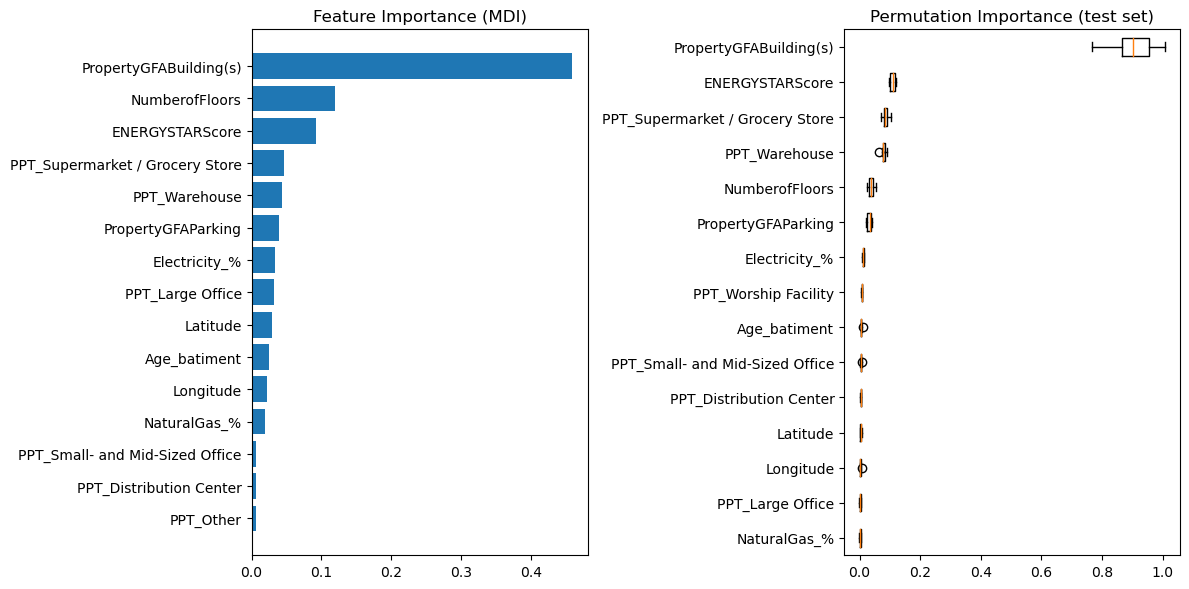

In [55]:
feature_importance = random_forest.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Tracer le graphique pour l'importance des features (MDI)
ax[0].barh(pos[-15:], feature_importance[sorted_idx][-15:], align="center")
ax[0].set_yticks(pos[-15:])
ax[0].set_yticklabels(np.array(X.columns)[sorted_idx][-15:])
ax[0].set_title("Feature Importance (MDI)")

# Tracer le graphique pour l'importance des features (permutation)
result = permutation_importance(
    random_forest, X_test, y_test, n_repeats=10, random_state=20, n_jobs=2
)
sorted_idx_perm = result.importances_mean.argsort()
ax[1].boxplot(
    result.importances[sorted_idx_perm].T[:, -15:],
    vert=False,
    labels=np.array(X.columns)[sorted_idx_perm][-15:],
)
ax[1].set_title("Permutation Importance (test set)")

plt.tight_layout()
plt.show()

In [53]:
# Determiner les SHAP values
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer(X_train_df)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


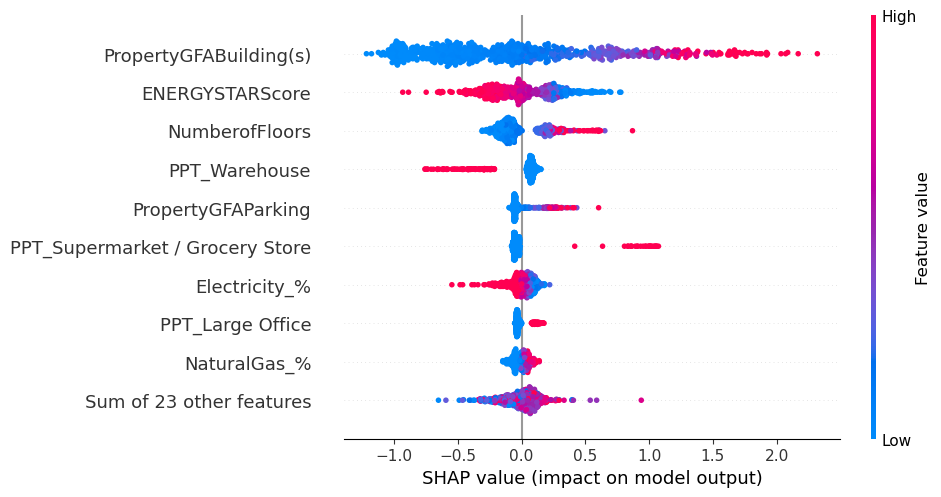

In [54]:
shap.plots.beeswarm(shap_values,max_display=10)

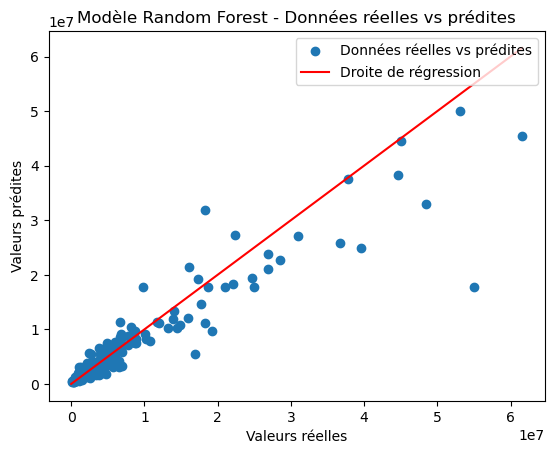

In [57]:
# Tracer un nuage de points entre les valeurs réelles et prédites
plt.scatter(np.exp(y_test), np.exp(y_pred), label='Données réelles vs prédites')

# Tracer la droite de régression linéaire entre valeurs réelles et prédites
max_value = max(np.max(np.exp(y_test)), np.max(np.exp(y_pred)))
plt.plot([0, max_value], [0, max_value], color='red', label='Droite de régression')

# Ajouter des labels et un titre
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Modèle Random Forest - Données réelles vs prédites')
plt.legend(loc='upper right')

# Limiter les axes pour une meilleure visualisation
# plt.xlim(-10000000, 100000000)
# plt.ylim(-10000000, 100000000)

plt.show()

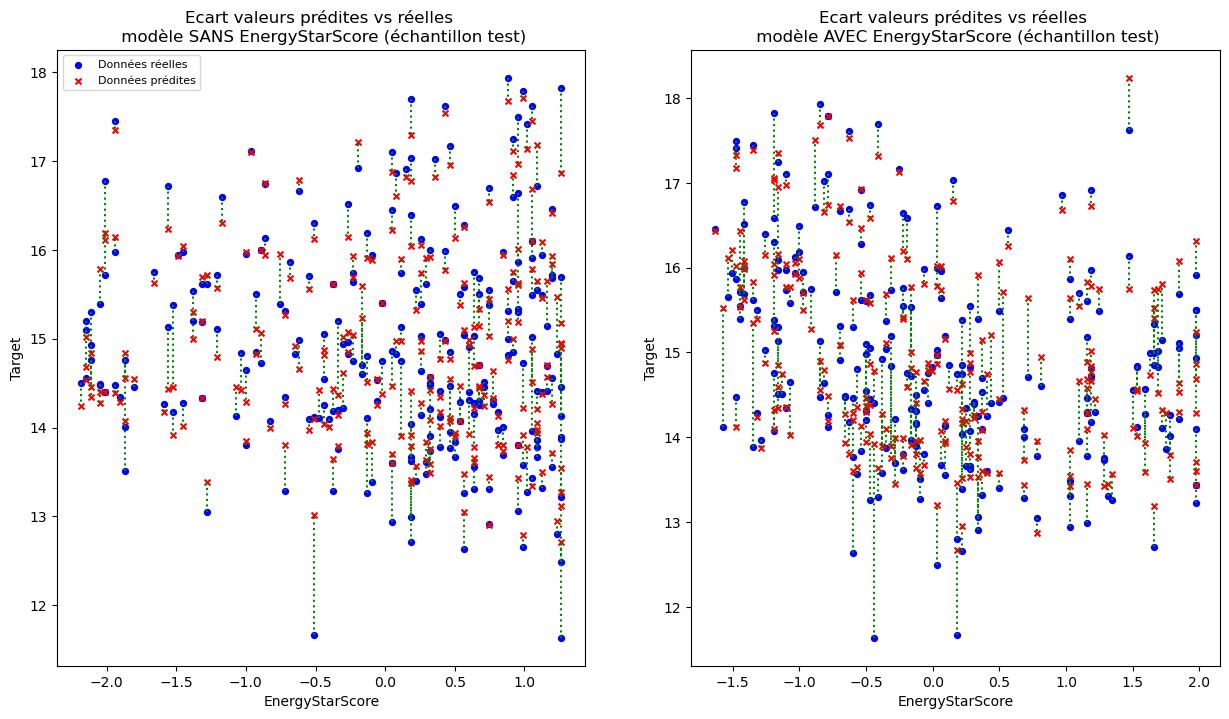

In [161]:
# Créer une figure et des sous-graphiques
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Tracer les valeurs réelles et prédites AVEC la variable EnergyStarScore intégrée dans le modèle
axs[0].scatter(X_test[:, -1], y_test, label='Données réelles', color='blue',s=18)
axs[0].scatter(X_test[:, -1], y_pred, label='Données prédites', color='red',s=18,marker='x')

# Tracer une ligne pointillée entre les valeurs réelles et prédites
for i in range(len(X_test)):
    axs[0].plot([X_test[i, -1], X_test[i, -1]], [np.array(y_test)[i], np.array(y_pred)[i]], color='green', linestyle='dotted')

# Ajouter les légendes
axs[0].legend(fontsize=8)
axs[0].set_title("Ecart valeurs prédites vs réelles \n modèle SANS EnergyStarScore (échantillon test)")
axs[0].set_xlabel('EnergyStarScore')
axs[0].set_ylabel('Target')

# Tracer les valeurs réelles et prédites SANS la variable EnergyStarScore intégrée dans le modèle
axs[1].scatter(X_test_Sscore[:, -1], y_test_Sscore, label='Données réelles', color='blue',s=18)
axs[1].scatter(X_test_Sscore[:, -1], y_pred_Sscore, label='Données prédites', color='red',s=18,marker='x')

# Tracer une ligne pointillée entre les valeurs réelles et prédites
for i in range(len(X_test_Sscore)):
    axs[1].plot([X_test_Sscore[i, -1], X_test_Sscore[i, -1]], [np.array(y_test_Sscore)[i], np.array(y_pred_Sscore)[i]], color='green', linestyle='dotted')

# Ajouter les légendes
axs[1].set_title("Ecart valeurs prédites vs réelles \n modèle AVEC EnergyStarScore (échantillon test)")
axs[1].set_xlabel('EnergyStarScore')
axs[1].set_ylabel('Target')

# Afficher le graphique
plt.show()